In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision import transforms
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import seaborn as sns
import matplotlib.style as style 
import matplotlib.pyplot as plt
style.use('ggplot')
# style.use('seaborn-poster') #sets the size of the charts

from tqdm import tqdm
import numpy as np
import sys
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, \
                            precision_score, recall_score, auc, roc_auc_score, \
                            confusion_matrix, roc_curve
from utils.print_pretty_confusion_matrix import plot_confusion_matrix_from_data 
sys.path.insert(0, 'dataloaders/')

from binary_data_loader import LAD_MPR_Loader

# Data Loading 

In [2]:
# test part
test_path_to_csv = '/home/petryshak/CoronaryArteryPlaqueIdentification/data/binary_classification_only_lad/train.csv'
test_path_to_data = '/home/petryshak/CoronaryArteryPlaqueIdentification/data/binary_classification_only_lad/'
lad_test = LAD_MPR_Loader(test_path_to_csv, test_path_to_data)
test_loader = torch.utils.data.DataLoader(lad_test,
                                             batch_size=64, 
                                             shuffle=False,
                                            )

# Model creation

In [3]:
PATH_TO_WEIGHTS = '/home/petryshak/CoronaryArteryPlaqueIdentification/weights/pretrained_resnet18_with_weights.pth'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(PATH_TO_WEIGHTS))
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

# Prediction

In [5]:
all_preds = []
all_labels = []
probas = []

model.eval()
with torch.no_grad():
    for imgs, labels in tqdm(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        softmax_logits = F.softmax(logits, dim=1)
        _,preds = torch.max(softmax_logits, 1)
        all_preds+= list(preds.cpu().numpy())
        all_labels+= list(labels.cpu().numpy())
        probas+= list(softmax_logits.detach().cpu().numpy())
    


100%|██████████| 434/434 [03:28<00:00,  2.46it/s]


In [6]:
print("Accuracy: ", accuracy_score(all_labels, all_preds))
print("Balanced accuracy: ", balanced_accuracy_score(all_labels, all_preds))
print("Precision: ", precision_score(all_labels, all_preds)) 
print("Recall: ", recall_score(all_labels, all_preds)) 
print("F1: ", f1_score(all_labels, all_preds))
print("ROC/AUC score: ", roc_auc_score(all_labels, [x[1] for x in probas]))


Accuracy:  0.8573642851993367
Balanced accuracy:  0.7886220198226781
Precision:  0.637026981164093
Recall:  0.6737257717157215
F1:  0.6548626253815961
ROC/AUC score:  0.8918656649119687


# Results visualization

In [7]:
def estimate_model(y_true, y_pred, pred_probas):
    """
    Calculated all main metrics for binary classification:
        - accuracy, 
        - balanced_accuracy, 
        - precision, 
        - recall, 
        - f1, 
        - roc_auc_score
    Returns:
        - dict: dictionary, key - is the name of metric, value - it`s value=)  
    """
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, pred_probas)
    return {'accuracy': accuracy , 'balanced_accuracy': balanced_accuracy, 'precision': precision, 'recall': recall, 
            'f1': f1, 'roc_auc': roc_auc}

def show_estimate_model(calculated_metrics_dict, color_palette="muted"):
    """
    Plots barplot of the metrics of the model
    
    Args:
        - model_calculated_metrics(dict): dictionary, key - is the name of metric, value - it`s value=)  
    """
    
    # Make a fake dataset
    height = [calculated_metrics_dict['accuracy'], calculated_metrics_dict['balanced_accuracy'], 
              calculated_metrics_dict['precision'], calculated_metrics_dict['recall'], calculated_metrics_dict['f1'], 
              calculated_metrics_dict['roc_auc']]
    bars = ("Accuracy", "Balanced accuracy", "Precision", "Recall", "F1", "ROC/AUC score")
    y_pos = np.arange(len(bars))
    print
    plt.figure(figsize=(20,10))
    plt.bar(y_pos, height, color=sns.color_palette(color_palette))
    plt.xticks(y_pos, bars, rotation=0, fontsize=20)
    plt.ylim(0,1)
    plt.yticks(list(plt.yticks()[0]) + [0.5, 0.7, 0.9, 0.1, 0.3], fontsize=20)

    for i in range(len(y_pos)) :
        plt.text(i - 0.22, height[i]+0.03, str(round(height[i], 3)), color='#696969', fontweight='bold', fontsize=22)
    
    plt.ylabel('Metric\'s value', fontsize=30)
    plt.show()
    
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

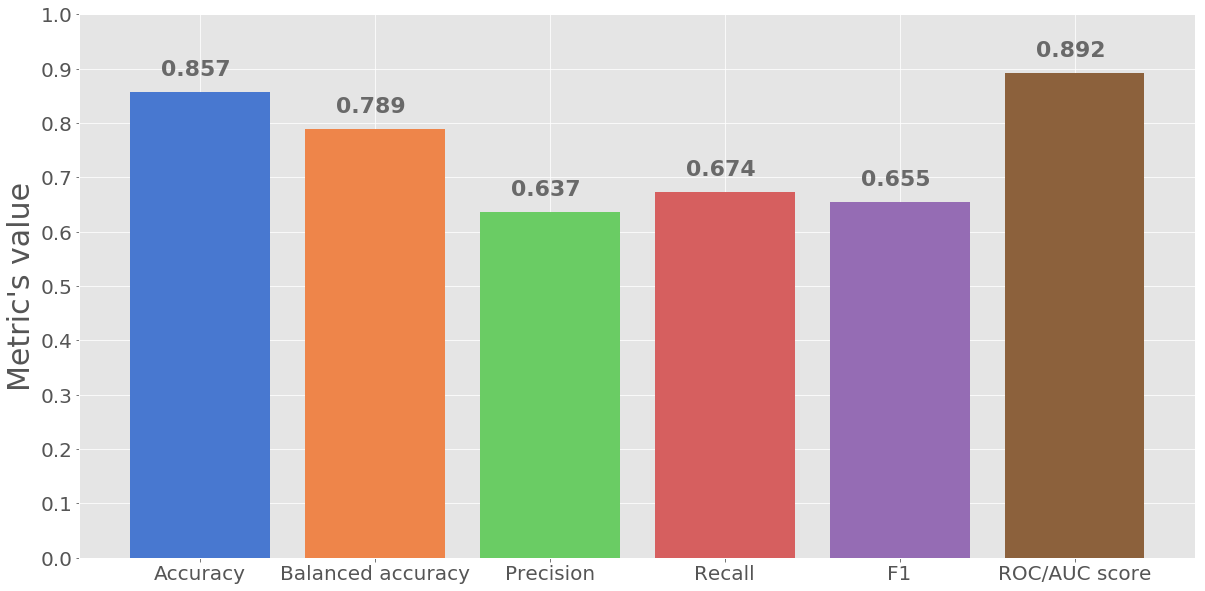

In [8]:
calculated_metrics_dict = estimate_model(all_labels, all_preds, [x[1] for x in probas])
show_estimate_model(calculated_metrics_dict)

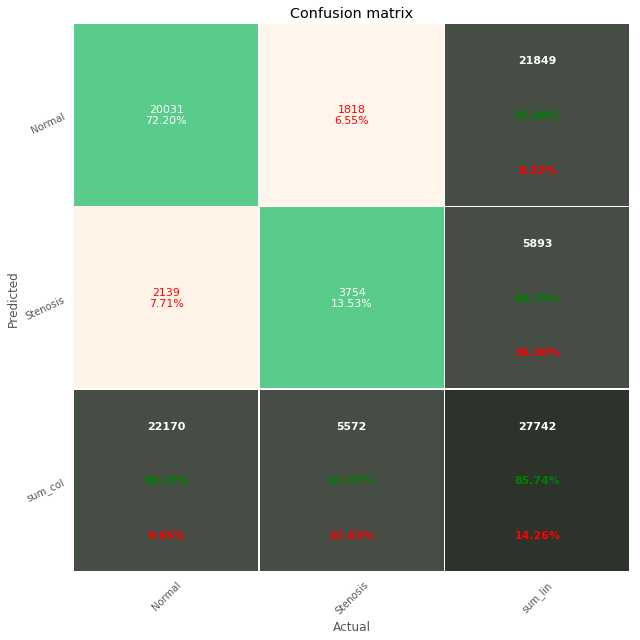

In [11]:
plot_confusion_matrix_from_data(all_labels, all_preds, columns=['Normal', 'Stenosis' ],
                               annot=True, cmap="Oranges",
                               fmt='.2f', fz=11, lw=0.5, cbar=False, 
                               figsize=[5,5], show_null_values=0, pred_val_axis='lin')

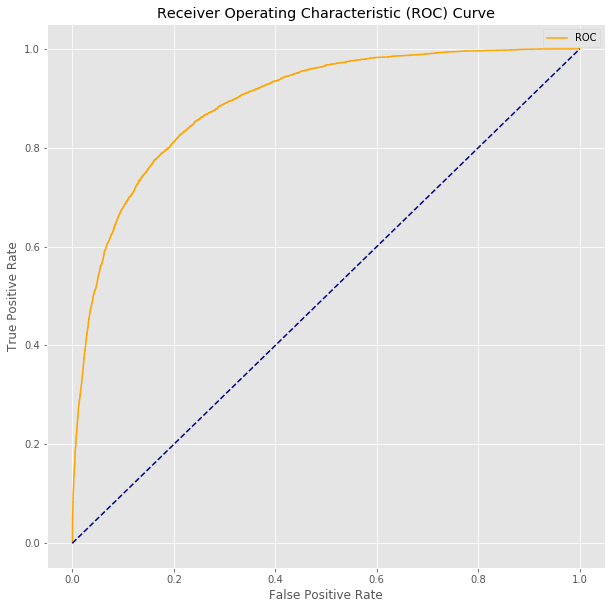

In [10]:
fpr, tpr, thresholds = roc_curve(all_labels,  [x[1] for x in probas ])  
plot_roc_curve(fpr, tpr)